# Постановка задачи

Необходимо реализовать предсказание настроений с помощью классических алгоритмов + tf-idf на основе данных твиттов и с помощью алгоритма наивного байеса.

# Описание набора данных

Представленный в этой рабочей тетради набор данных содержит размеченные твиты. Метка со значением "1" говорит о том, что твит несет в себе негативный посыл, в свою очередь твит с меткой "0" таковым не является.

Моей задачей будет предсказать метки для каждого твита.

#Начало работы с данными

##Импорт, ознакомление и предобработка

In [ ]:
# импортируем необходимые для дальнейшей работы библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import ComplementNB, MultinomialNB, BernoulliNB, CategoricalNB, GaussianNB
from sklearn.feature_extraction import _stop_words
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# создаем датафрейм
df = pd.read_csv('/train.csv')

In [ ]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
# удаляю колонку 'id', т.к. в дальнейшем хочу работать только со столбцом-признаком
# и столбцом-таргетом, признак 'id' в данной задаче не играет никакой роли
df = df.drop('id', axis=1)
df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [ ]:
df.shape

(31962, 2)

In [ ]:
# стандартная проверка на дубликаты и пропуски
df_shape = df.shape[0]
df = df.drop_duplicates()
print(f'Удалено дубликатов: {df_shape - df.shape[0]}')
print('-----'*4)
print('Null:')
df.isnull().any()

Удалено дубликатов: 2432
--------------------
Null:


label    False
tweet    False
dtype: bool

In [ ]:
'''
standardize_text - функция, которая принимает на вход датафрейм и один из
признаков датафрейма, проходится по всем элементам указанного признака,
приводит текст в каждом элементе к единому формату с помощью регулярных
выражений.
Возвращает датафрейм с примененными изменениями.
'''

def standardize_text(df, feature):
    # избавляемся от знаков пунктуации и спецсимволов
    df[feature] = df[feature].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[feature] = df[feature].str.replace(r"\'", "")
    df[feature] = df[feature].str.replace(r"http\S+", "")
    df[feature] = df[feature].str.replace(r"http", "")
    df[feature] = df[feature].str.replace(r"@\S+", "")
    df[feature] = df[feature].str.replace(r"@", "at")
    # переводим слова в нижний регистр
    df[feature] = df[feature].str.lower()
    # избавляемся от пробелов в начале и в конце строки
    df[feature] = df[feature].str.strip()
    return df

df = standardize_text(df, "tweet")
df.head()

,label,tweet
0,0,when a father is dysfunctional and is so selfi...
1,0,thanks for lyft credit i cant use cause they ...
2,0,bihday your majesty
3,0,model i love u take with u all the time in u...
4,0,factsguide society now motivation


In [ ]:
# проверка баланса классов в столбце с целевыми метками
df.groupby('label').count()

,tweet
label,
0,27517
1,2013


Из вывода ячейки выше мы сразу можем отметить что в наборе данных наблюдается сильный дисбаланс классов. Твиттов с негативным посылом в 13,5 раз больше, чем позитивных твиттов.

Нужно обратить на это внимание, т.к. необходима аугментация признаков для более лучшей способности модели распознавать миноритарный класс (с меткой "1").

# Наивный байес

Достаточно часто в задачах классификации текста используют наивный байесовский классификатор для болучения бейзлайна. Основные его преимущества — простота реализации и низкие вычислительные затраты при обучении и классификации. В тех редких случаях, когда признаки почти независимы, наивный байесовский классификатор близок к оптимальному. Достаточно малое количество данных необходимо для обучения, оценки параметров и классификации.

Посмотреть на подробное описание и реализацию наивного байесовского классификатора **с нуля** можно в моей рабочей тетради на гитхабе по ссылке: [Lightmourne/NLP/Классификация текста/Реализация _алгоритма_наивного_байеса_на_примере_классификации_текста.ipynb](https://github.com/Lightmourne/NLP/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F%20%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0/%D0%A0%D0%B5%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F%20_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D0%B0_%D0%BD%D0%B0%D0%B8%D0%B2%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B1%D0%B0%D0%B9%D0%B5%D1%81%D0%B0_%D0%BD%D0%B0_%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D1%80%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D0%B8_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0.ipynb)

Для того чтобы наша модель смогла обрабатывать текстовую последовательность, необходимо закодировать слова (векторизировать). Существует несколько подходов векторизации, один из них называется *COUNTVECTORIZER*.

CountVectorizer считает встречаемость слов в документе. Под документом может подразумеваться предложение, абзац, пост или комментарий. Результатом применения CountVectorizer являются разреженные вектора (sparse vectors), причём значения сортированы согласно частоте встречаемости слова.

Как и в случае с one-hot кодированием каждый документ будет являться вектором фиксированной длины. Каждое уникальное слово в тексте - новый признак (колонка). Вместо индикатора вхождения слова - количество появлений в тексте.

Минусы:

*   Частота появления слова - не лучший показатель важности для текста (предлоги, союзы, прочие часто встречающиеся признаки)
*   Большое пространство признаков (стоит задуматься о понижении размерности)
*   Теряются пространственные зависимости в тексте



## CountVectorizer

In [ ]:
vectorizer = CountVectorizer(binary=True)
vectorizer.fit(df['tweet'])

CountVectorizer(binary=True)

In [ ]:
# разделим датафрейм на тренировочную (80%) и тестовую часть (20%)
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
df_train

,label,tweet
7753,0,3 steps to happiness! blogger happiness ...
7000,0,waiting in the dark for my first film of whic...
31749,0,the strength of our motivation is such honest ...
30265,0,"if you can put this up here, you can as well ..."
29003,1,hes shown us over amp over who he is! bigly...
...,...,...
23170,0,thinking of the parents of 2 yr old toddler wh...
5614,0,not a serious pic the sun was in my eye!!! l...
880,0,so woh the wait! doubledown my wife is ...
16845,0,i think im the only person tweeting about this


Векторизируем твиты в обеих выборках

In [ ]:
X_train = vectorizer.transform(df_train['tweet'])

In [ ]:
X_test = vectorizer.transform(df_test['tweet'])

Инициализируем и обучим три разновидности классификатора наивного байеса из библиотеки sklearn для получения бейзлайна (MultinomialNB, ComplementNB, BernoulliNB)

In [ ]:
clf = MultinomialNB().fit(X_train, df_train['label'])
predicts = clf.predict(X_test)
print(classification_report(df_test['label'], predicts))

# для сравнения macro f1 в конце исследования
score_cvectorizer = precision_recall_fscore_support(df_test['label'],
                                                    predicts,
                                                    average='macro')[2]

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5498
           1       0.59      0.42      0.49       408

    accuracy                           0.94      5906
   macro avg       0.78      0.70      0.73      5906
weighted avg       0.93      0.94      0.94      5906



Наивный байесовский классификатор ComplementNB был разработан для исправления «грубых допущений», сделанных стандартным полиномиальным наивным байесовским классификатором. Хорошо работает с несбалансированным набором данных.

CNB - это адаптация стандартного полиномиального наивного байесовского алгоритма (MNB), который особенно подходит для несбалансированных наборов данных. В частности, CNB использует статистику из дополнения каждого класса для вычисления весов модели. Изобретатели CNB эмпирически показывают, что оценки параметров для CNB более стабильны, чем оценки для MNB. Кроме того, CNB регулярно опережает MNB (часто со значительным отрывом) по задачам классификации текста.

In [ ]:
clf = ComplementNB().fit(X_train, df_train['label'])
predicts = clf.predict(X_test)
print(classification_report(df_test['label'], predicts))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      5498
           1       0.42      0.60      0.49       408

    accuracy                           0.91      5906
   macro avg       0.69      0.77      0.72      5906
weighted avg       0.93      0.91      0.92      5906



In [ ]:
clf = BernoulliNB().fit(X_train, df_train['label'])
predicts = clf.predict(X_test)
print(classification_report(df_test['label'], predicts))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97      5498
           1       0.95      0.05      0.10       408

    accuracy                           0.93      5906
   macro avg       0.94      0.53      0.53      5906
weighted avg       0.94      0.93      0.91      5906



На нашем датасете MultinomialNB и ComplementNB показывают схожие результаты

## Bag of words

In [ ]:
count_vectorizer = CountVectorizer(binary=False)
count_vectorizer.fit(df['tweet'])

X_train_counts = count_vectorizer.transform(df_train['tweet'])
X_test_counts = count_vectorizer.transform(df_test['tweet'])

In [ ]:
clf = MultinomialNB().fit(X_train_counts, df_train['label'])
predicts = clf.predict(X_test_counts)
print(classification_report(df_test['label'], predicts))

# для сравнения macro f1 в конце исследования
score_bag_of_words = precision_recall_fscore_support(df_test['label'],
                                                     predicts,
                                                     average='macro')[2]

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5498
           1       0.57      0.41      0.48       408

    accuracy                           0.94      5906
   macro avg       0.76      0.69      0.72      5906
weighted avg       0.93      0.94      0.93      5906



In [ ]:
clf = ComplementNB().fit(X_train_counts, df_train['label'])
predicts = clf.predict(X_test_counts)
print(classification_report(df_test['label'], predicts))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      5498
           1       0.41      0.61      0.49       408

    accuracy                           0.91      5906
   macro avg       0.69      0.77      0.72      5906
weighted avg       0.93      0.91      0.92      5906



In [ ]:
'''
следующая ячейка с CountVectorizer не запускалась с импортированным _stop_words
поэтому мне пришлось создать эту ячейку с множеством "ENGLISH_STOP_WORDS"
для явной передачи множества в аргумент "stop_words"
"ENGLISH_STOP_WORDS" - frozenset ([i, and, am, you, else, ... и т.д.])
это часто встречающиеся в языке слова, при избавлении от которых можно
доиться лучшего качества предсказаний модели
'''
from stop_words import ENGLISH_STOP_WORDS

In [ ]:
# уберем часто встречающиеся слова
count_vectorizer = CountVectorizer(stop_words=ENGLISH_STOP_WORDS, binary=False)
count_vectorizer.fit(df['tweet'])
X_train_counts = count_vectorizer.transform(df_train['tweet'])
X_test_counts = count_vectorizer.transform(df_test['tweet'])

In [ ]:
clf = MultinomialNB().fit(X_train_counts, df_train['label'])
predicts = clf.predict(X_test_counts)
print(classification_report(df_test['label'], predicts))

# для сравнения macro f1 в конце исследования
score_bag_of_words_drop_stopwords = precision_recall_fscore_support(df_test['label'],
                                                                    predicts,
                                                                    average='macro')[2]

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      5498
           1       0.57      0.52      0.55       408

    accuracy                           0.94      5906
   macro avg       0.77      0.75      0.76      5906
weighted avg       0.94      0.94      0.94      5906



In [ ]:
clf = ComplementNB().fit(X_train_counts, df_train['label'])
predicts = clf.predict(X_test_counts)
print(classification_report(df_test['label'], predicts))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      5498
           1       0.35      0.75      0.48       408

    accuracy                           0.89      5906
   macro avg       0.66      0.82      0.71      5906
weighted avg       0.94      0.89      0.90      5906



После того как из текста убрали стоп-слова оцена macro avg f1-score у алгоритма MultinomialNB() увеличилась на 3 процентных пункта

##  Аугментация текстовых данных

Один из подходов к аугментации такстовых данных - Easy Data Augmentation ([EDA: Easy Data Augmentation Techniques for Boosting Performance on Text Classification Tasks](https://github.com/jasonwei20/eda_nlp))

EDA заключается в выполнении ряда операций, таких как:

*   **Synonym Replacement (SR)**: Случайным образом из предложения выбираются n-слов (не должны быть стоп-словами), далее производится замена каждого из этих слов его случайным синонимом.
*   **Random Insertion (RI)**: Для случайного слова в предложении находят синоним, после чего вставляют этот синоним в случайное место в этом предложении. Повторяйте это n-раз.
*   **Random Swap (RS)**: Случайным образом выбирают два слова в предложении и меняют их местами. Повторяйте это n-раз.
*   **Random Deletion (RD)**: Каждое слово в предложении может быть удалено с некоторой вероятностью.



#### Synonym Replacement (SR)

Для определения [лемм](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BC%D0%BC%D0%B0_(%D0%BB%D0%B8%D0%BD%D0%B3%D0%B2%D0%B8%D1%81%D1%82%D0%B8%D0%BA%D0%B0)) синонимов можно воспользоваться wordnet из nltk.corpus

In [ ]:
# скачиваю библиотеку Natural Language Toolkit
!pip install -U nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import wordnet


def get_synonyms(word):
    """
    Функция для подбора синонима для конкретного слова
    """
    synonyms = set()

    for syn in nltk.corpus.wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)

    return list(synonyms)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# импортируем стоп-слова из NLTK и запишем их в список stop_words
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = []
for word in stopwords.words('english'):
    stop_words.append(word)
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import random

'''
Функция synonym_replacement(words, n) принимает на вход строку 'words', сплитит
строку по словам и производит замену случайных n-слов в этой строке на синонимы
при условии что это слово не находится в списке 'stop_words'
Подбор синонима для слова осуществляется с помощью функции get_synonyms(word)
'''
def synonym_replacement(words, n):

    words = words.split()

    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0

    for random_word in random_word_list:
        synonyms = get_synonyms(random_word) # получаем список синонимов для слова

        # выбираем один из синонимов случайным образом, если их более одного
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1

        # выходим из цикла, если количество синонимов достигло n
        if num_replaced >= n:
            break

    sentence = ' '.join(new_words)

    return sentence

Я решил что буду создавать пандас датафреймы для каждого подхода (Synonym Replacement (SR), Random Insertion (RI), Random Swap (RS), Random Deletion (RD)), после чего сконкатенирую их с нашим исходным df, тем самым получится увеличить количество твитов одного из классов для устранения дисбаланса.

In [ ]:
# создаю датафрейм для твитов после Synonym Replacement (SR), пока в нем будут
# только пустые колонки

df_with_synonym_replacement = pd.DataFrame(columns=['label', 'tweet'])

# пишу цикл, в котором буду брать каждый из твитов с меткой = 1, применять к
# нему функцию synonym_replacement с аргументом n=3 для замены 3 слов,
# после преобразования строки записываю получившуюся строку и её лейбл в датасет
for i in df[df.label == 1]['tweet'].reset_index(drop=True).to_list():
    label = 1
    tweet = synonym_replacement(i, 3)
    new_row = {'label': 1,
               'tweet': str(tweet)}
    df_with_synonym_replacement = df_with_synonym_replacement.append(new_row, ignore_index=True)

#### Random Deletion (RD)



In [ ]:
def random_deletion(words, probability):

    words = words.split()

    # если твит содержит только одно слово, то функция не будет его удалять
    if len(words) == 1:
        return words

    # удаляем случайное слово, если случайно сгенерированное число будет меньше
    # значения probability, переданного в аргумент функции
    new_words = []
    for word in words:
        random_probability = random.random()
        if random_probability > probability:
            new_words.append(word)

    # если все слова были удалены, то вернем одно из слов случайным образом
    if len(new_words) == 0:
        rand_int = random.randint(0, len(words)-1)
        return [words[rand_int]]

    sentence = ' '.join(new_words)

    return sentence

In [ ]:
# тестирование оптимального значения probability
print('Исходный твит:')
print(df[df.label == 1]['tweet'].reset_index(drop=True).to_list()[0])
print('----'*9)

for i in np.linspace(0.1, 0.5, 5):
    print(f'probability = {i}')
    sentence = random_deletion(df[df.label == 1]['tweet'].reset_index(drop=True).to_list()[0], i)
    print(sentence)
    print('----'*3)

Исходный твит:
cnn calls  michigan middle school build the wall chant   tcot
------------------------------------
probability = 0.1
cnn calls michigan middle school build the wall chant tcot
------------
probability = 0.2
cnn calls middle the wall chant tcot
------------
probability = 0.30000000000000004
calls middle school build the chant tcot
------------
probability = 0.4
cnn calls middle school build
------------
probability = 0.5
middle school build the wall tcot
------------


Кажется оптимальным использовать знаение равное 0.3

In [ ]:
df_with_random_deletion = pd.DataFrame(columns=['label', 'tweet'])

# удаляю слово, если случайным образом выпадет число меньше 0.3
for i in df[df.label == 1]['tweet'].reset_index(drop=True).to_list():
    label = 1
    tweet = random_deletion(i, 0.3)
    new_row = {'label': 1,
               'tweet': str(tweet)}
    df_with_random_deletion = df_with_random_deletion.append(new_row, ignore_index=True)

#### Random Swap (RS)

In [ ]:
'''
функция swap_word(new_words) меняет местами слова в твите
первоначально присваиваем a и b одинаковое случайное значение
для перестановки нужно чтобы b случайным образом приняло отличное от a значение
'''

def swap_word(new_words):

    a = random.randint(0, len(new_words)-1)
    b = a
    counter = 0

    while b == a:
        b = random.randint(0, len(new_words)-1)
        counter += 1

        # если 3 раза подряд для b выпало число равное a, то
        # возвращаем new_words
        if counter > 3:
            return new_words

    new_words[a], new_words[b] = new_words[b], new_words[a]
    return new_words

In [ ]:
'''
функция random_swap(words, n) работает на основе swap_word(new_words)
в words передаем твит, сплитим его, результат сплита передаем в swap_word(new_words),
n - количество слов в твите для перестановки
'''

def random_swap(words, n):

    words = words.split()
    new_words = words.copy()

    for _ in range(n):
        new_words = swap_word(new_words)

    sentence = ' '.join(new_words)

    return sentence

In [ ]:
# сложно сказать сколько слов можно менять местами, так как конечный результат
# зависит от конкретной перестановки, и в результате перестановки даже небольшого
# количества слов может нарушиться семантика
# в связи с этим попробую менять местами только 2 слова

df_with_random_swap = pd.DataFrame(columns=['label', 'tweet'])

for i in df[df.label == 1]['tweet'].reset_index(drop=True).to_list():
    label = 1
    tweet = random_swap(i, 2)
    new_row = {'label': 1,
               'tweet': str(tweet)}
    df_with_random_swap = df_with_random_swap.append(new_row, ignore_index=True)

#### Random Insertion (RI)

In [ ]:
def add_word(new_words):

    synonyms = []
    counter = 0

    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words)-1)]
        synonyms = get_synonyms(random_word)
        # print(random_word, get_synonyms(random_word))
        counter += 1
        if counter >= 10:
            return

    random_synonym = synonyms[0]
    index = random.randint(0, len(new_words)-1)
    new_words.insert(index, random_synonym)

In [ ]:
def random_insertion(words, n):

    words = words.split()
    new_words = words.copy()

    for _ in range(n):
        add_word(new_words)

    sentence = ' '.join(new_words)
    return sentence

In [ ]:
df_with_random_insertion = pd.DataFrame(columns=['label', 'tweet'])

for i in df[df.label == 1]['tweet'].reset_index(drop=True).to_list():
    label = 1
    tweet = random_insertion(i, 3)
    new_row = {'label': 1,
               'tweet': str(tweet)}
    df_with_random_insertion = df_with_random_insertion.append(new_row, ignore_index=True)

Проверка работы функций на примере одного из твитов

In [ ]:
print('Исходная строка:', df[df.label == 1]['tweet'].reset_index(drop=True)[11])
print()
print('Строка с заменой слов на синонимы:', df_with_synonym_replacement['tweet'][11])
print()
print('Строка с удалением случайных слов:', df_with_random_deletion['tweet'][11])
print()
print('Строка с перестановкой случайных слов местами:', df_with_random_swap['tweet'][11])
print()
print('Строка с вставками синонимов в случайные места:', df_with_random_insertion['tweet'][11])

Исходная строка: people arent protesting  trump because a  republican won they do so because trump has fuhered   amp

Строка с заменой слов на синонимы: citizenry arent resist trump because a republican won they do so because trump has fuhered adenosine monophosphate

Строка с удалением случайных слов: people arent protesting trump because a republican won so because fuhered

Строка с перестановкой случайных слов местами: because arent protesting trump a people republican won they do so because trump has fuhered amp

Строка с вставками синонимов в случайные места: ampere people arent protesting trump because a republican won they do so because make headway trump has type a fuhered amp


In [ ]:
# создаю новый датафрейм склеивая исходный и четыре датафрейма,
# полученные в результате аугментации

df_augm = pd.concat([df,
                     df_with_synonym_replacement,
                     df_with_random_deletion,
                     df_with_random_swap,
                     df_with_random_insertion],
                     ignore_index=True,
                     sort=False)


Посмотрим на баланс признаков после применения аугментации к минориторному классу

In [ ]:
df_augm.groupby('label').count()

,tweet
label,
0,27517
1,10065


Дисбаланс сохранился, но он стал гораздо меньше. Ранее дисбаланс составлял 13,5 раз, теперь элементов класса "0" больше в 2,7 раз, чем элементов класса "1", что должно дать ощутимый прирост в качестве прогнозирования целевых классов алгоритмом.

In [ ]:
from sklearn.utils import shuffle
df_augm_shuffle = shuffle(df_augm, random_state=11).reset_index(drop=True)
df_augm_shuffle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37582 entries, 0 to 37581
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   37582 non-null  object
 1   tweet   37582 non-null  object
dtypes: object(2)
memory usage: 587.3+ KB


In [ ]:
# столбец label получил тип 'object', приведем его к целочисленному типу
df_augm_shuffle['label'] = df_augm_shuffle['label'].astype(np.int64)

## Проверка работы моделей на новом датасете




In [ ]:
# тот же Bag of words
count_vectorizer = CountVectorizer(stop_words=ENGLISH_STOP_WORDS, binary=False)
count_vectorizer.fit(df_augm_shuffle['tweet'])

df_augm_train, df_augm_test = train_test_split(df_augm_shuffle,
                                               test_size=0.2,
                                               shuffle=True,
                                               random_state=42)
X_train_counts_augm = count_vectorizer.transform(df_augm_train['tweet'])
X_test_counts_augm = count_vectorizer.transform(df_augm_test['tweet'])

In [ ]:
clf = MultinomialNB().fit(X_train_counts_augm, df_augm_train['label'])
predicts = clf.predict(X_test_counts_augm)
print(classification_report(df_augm_test['label'], predicts))

score_bag_of_words_augm = precision_recall_fscore_support(df_augm_test['label'],
                                                          predicts,
                                                          average='macro')[2]

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      5512
           1       0.84      0.93      0.88      2005

    accuracy                           0.93      7517
   macro avg       0.91      0.93      0.92      7517
weighted avg       0.94      0.93      0.93      7517



In [ ]:
clf = ComplementNB().fit(X_train_counts_augm, df_augm_train['label'])
predicts = clf.predict(X_test_counts_augm)
print(classification_report(df_augm_test['label'], predicts))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      5512
           1       0.77      0.95      0.85      2005

    accuracy                           0.91      7517
   macro avg       0.88      0.93      0.89      7517
weighted avg       0.93      0.91      0.91      7517



С помощью гридсерча переберем и найдем оптимальный гиперпараметр альфа для MultinomialNB

In [ ]:
%%time
# пишем конвеер
pipe = Pipeline(steps=[('mNB', MultinomialNB())])

# задаем параметры
parameters = {'mNB__alpha': np.linspace(0, 1, 10)}

gs = GridSearchCV(pipe, parameters, cv = 5, n_jobs=-1, verbose = 1, scoring = 'f1')
gs.fit(X_train_counts_augm, df_augm_train['label'])
print(f'best params (cross-val on train): {gs.best_params_}\nr2: {gs.best_score_}')

predicts = gs.predict(X_test_counts_augm)
print('MSE test:', mean_squared_error(df_augm_test['label'], predicts))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
best params (cross-val on train): {'mNB__alpha': 0.0}
r2: 0.9055256990943527
MSE test: 0.05148330450977784
CPU times: user 513 ms, sys: 152 ms, total: 665 ms
Wall time: 3.19 s


In [ ]:
# функция для отрисовки графика
def grid_plot(x, y, x_label, title, y_label='r2'):
    # определили размер графика
    plt.figure(figsize=(12, 6))
    # добавили сетку на фон
    plt.grid(True)
    # построили по х - число соседей, по y - точность
    plt.plot(x, y, 'go-')
    # добавили подписи осей и название графика
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

Визуализируем изменение коэффициента детерминации при обучении классификатора MultinomialNB с разным гиперпараметром альфа  

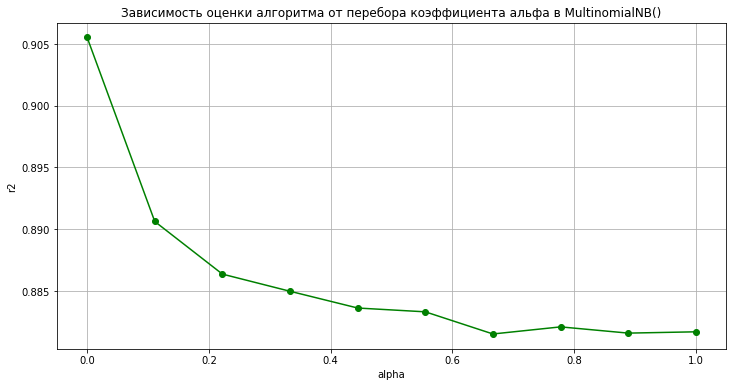

In [ ]:
# визуализация зависимости качества от значения коэф-та альфа
grid_plot(parameters['mNB__alpha'],
          gs.cv_results_['mean_test_score'],
          'alpha',
          'Зависимость оценки алгоритма от перебора коэффициента альфа в MultinomialNB()')

In [ ]:
# запускаю переобучение алгоритма с наилучшим параметром альфа
clf = MultinomialNB(alpha=0).fit(X_train_counts_augm, df_augm_train['label'])
predicts = clf.predict(X_test_counts_augm)
print(classification_report(df_augm_test['label'], predicts))

score_bag_of_words_augm_with_alpha = precision_recall_fscore_support(df_augm_test['label'],
                                                                     predicts,
                                                                     average='macro')[2]

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      5512
           1       0.87      0.95      0.91      2005

    accuracy                           0.95      7517
   macro avg       0.93      0.95      0.94      7517
weighted avg       0.95      0.95      0.95      7517



Визуализируем результат работы алгоритма на тестовой выборке.

Построим график "кривой ошибок" и матрицу ошибок.

 Для бинарных ответов алгоритма ROC-кривая будет проходить через три точки с координатами [(0,0), (FPR, TPR), (1, 1)].

В формульном виде AUC ROC для бинарного решения:

 $$\frac{TPR \cdot FPR}{2} + TPR \cdot (1 - FPR) + \frac{(1 - TPR) \cdot (1-FPR)}{2} = \frac{1 + TPR - FPR}{2}$$

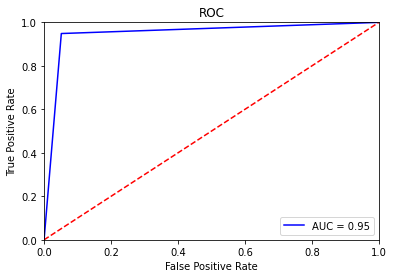

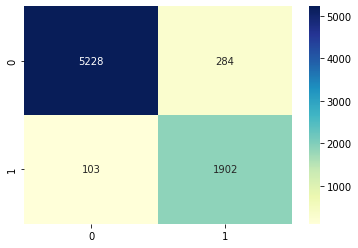

In [ ]:
fpr, tpr, threshold = roc_curve(df_augm_test['label'], predicts)
roc_auc = auc(fpr, tpr)
plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
sns.heatmap(confusion_matrix(df_augm_test['label'], predicts),
            annot = True,
            fmt='',
            cmap="YlGnBu")

Визуализируем прирост macro avg f1-score с бейзлайна до конечного результата после всех примененных техник

Прирост macro avg f1-score после аугментации составил: 16.0%
---
Прирост в совокупности начиная с простого count vectorizer заканчивая перебором параметра альфа составил: 21.0%


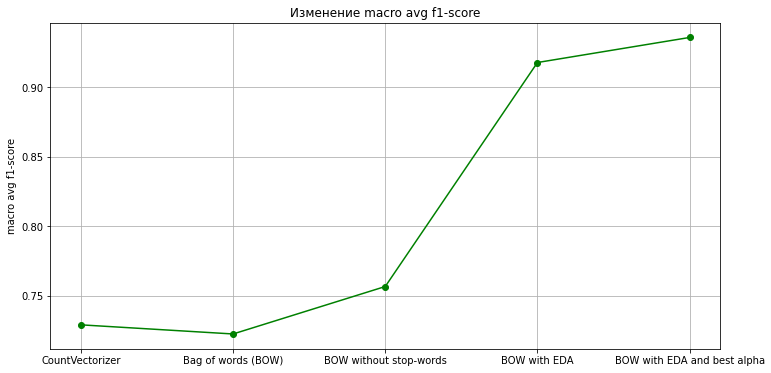

In [ ]:
score_names = ['CountVectorizer',
               'Bag of words (BOW)',
               'BOW without stop-words',
               'BOW with EDA',
               'BOW with EDA and best alpha']
score_values = [score_cvectorizer,
                score_bag_of_words,
                score_bag_of_words_drop_stopwords,
                score_bag_of_words_augm,
                score_bag_of_words_augm_with_alpha]
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(score_names, score_values, 'go-')
plt.ylabel('macro avg f1-score')
plt.title('Изменение macro avg f1-score')

print(f'Прирост macro avg f1-score после аугментации составил: {round((score_bag_of_words_augm - score_bag_of_words_drop_stopwords), 2) * 100}%')
print('---')
print(f'Прирост в совокупности начиная с простого count vectorizer заканчивая перебором параметра альфа составил: {round((score_bag_of_words_augm_with_alpha - score_cvectorizer), 2) * 100}%')

## Промежуточный вывод

Из графика выше видно что максимальный прирост оценки macro f1-score был получен после аугментации данных (16% относительно Bag of words при исключении стоп-слов).

В результате всех проведенных действий удалось повысить метрику macro avg f1-score на 21% относительно CountVectorizer, её значение составляет 0.94, что я считаю неплохим результатом.

#TF-IDF и классические линейные модели

TF-IDF (от англ. TF — term frequency, IDF — inverse document frequency) — статистический показатель, применяемый для оценки важности слова в контексте категории, документа или коллекции документов. Используется при анализе текстовых данных.

Как правило, TF-IDF определяется для каждого слова. Чем выше значение данного показателя, тем значимее слово в контексте категории, документа, коллекции. При этом данный показатель также позволяет учесть и широкоупотребляемые слова, понизив их значимость в контексте объекта для анализа.

Как и в случае count vectorizer каждый документ - вектор фиксированной длины. Каждое уникальное слово в тексте - новый признак (колонка). Вместе количество появлений в тексте - это количественно умноженное на обратную частоту встречания (гасим слишком частые слова).

Недостатки:

*   Большое пространство признаков (стоит задуматься о понижении размерности)
*   Теряются пространственные зависимости в тексте





In [ ]:
vectorizer = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS)
vectorizer = vectorizer.fit(df_augm_shuffle['tweet'])

df_augm_train_tfidf, df_augm_test_tfidf = train_test_split(df_augm_shuffle,
                                                           test_size=0.2,
                                                           shuffle=True,
                                                           random_state=42)

X_train_vectors = vectorizer.transform(df_augm_train_tfidf['tweet'])
X_test_vectors = vectorizer.transform(df_augm_test_tfidf['tweet'])

##LogisticRegression

In [ ]:
logreg = LogisticRegression(class_weight = 'balanced')

logreg.fit(X_train_vectors, df_augm_train_tfidf['label'])
predicts = logreg.predict(X_test_vectors)
print(classification_report(df_augm_test_tfidf['label'], predicts))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      5512
           1       0.86      0.94      0.90      2005

    accuracy                           0.94      7517
   macro avg       0.92      0.94      0.93      7517
weighted avg       0.95      0.94      0.94      7517



##SVC

In [ ]:
svc = SVC(class_weight = 'balanced').fit(X_train_vectors, df_augm_train_tfidf['label'])
predicts = svc.predict(X_test_vectors)
print(classification_report(df_augm_test_tfidf['label'], predicts))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5512
           1       0.96      0.94      0.95      2005

    accuracy                           0.97      7517
   macro avg       0.97      0.96      0.97      7517
weighted avg       0.97      0.97      0.97      7517



# Заключение
Аугментация, как и ожидалось, дала хороший прирост оценке macro avg f1-score.

Лучшие результаты показали:


*   SVC | macro avg f1-score = 0.97
*   MultinomialNB(alpha=0) | macro avg f1-score = 0.94

